In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.style.use('./paper.mcstyle')

import matplotlib.cm as cm
import pandas as pd
import dask.dataframe as dd
from dask import delayed
from multiprocessing import cpu_count
from multiprocessing import Pool
from sklearn.neighbors import NearestNeighbors
from ili.validation.metrics import PosteriorCoverage


import torch
import os
import time
import CASBI.sbi.inference as inference
from CASBI.utils.create_template_library import TemplateLibrary



gpu_index = 6  # replace with your desired GPU index
torch.cuda.set_device(gpu_index)
device = f"cuda:{gpu_index}"

# test

In [4]:
! cd /export/data/vgiusepp/ ; ls

analysis  analysis_hist  analysis_ratio  complete_inference  data


In [8]:
! cd /export/data/vgiusepp/data/full_dataframe/; ls

dataframe  galaxy_array  histogram_data  preprocess


In [9]:
data = pd.read_parquet('/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet')

In [12]:
data.head()

,feh,ofe,star_log10mass,gas_log10mass,dm_log10mass,infall_time,redshift,a,mean_metallicity,mean_FeMassFrac,mean_OMassFrac,std_metallicity,std_FeMassFrac,std_OMassFrac,Galaxy_name
0,-2.554862,0.088439,6.789908,8.656723,9.694663,1.311857,4.561225,0.179816,0.000137,0.000006,0.000063,0.000086,0.000004,0.00004,g1.05e11.00096
1,-2.120942,0.106902,6.789908,8.656723,9.694663,1.311857,4.561225,0.179816,0.000137,0.000006,0.000063,0.000086,0.000004,0.00004,g1.05e11.00096
2,-2.571109,-0.159409,6.789908,8.656723,9.694663,1.311857,4.561225,0.179816,0.000137,0.000006,0.000063,0.000086,0.000004,0.00004,g1.05e11.00096
3,-2.605765,0.170587,6.789908,8.656723,9.694663,1.311857,4.561225,0.179816,0.000137,0.000006,0.000063,0.000086,0.000004,0.00004,g1.05e11.00096
4,-2.457028,0.232366,6.789908,8.656723,9.694663,1.311857,4.561225,0.179816,0.000137,0.000006,0.000063,0.000086,0.000004,0.00004,g1.05e11.00096


In [18]:
! cd /export/data/vgiusepp/data/full_dataframe/galaxy_array/;  ls

In [2]:
def save_galaxy_data(galaxy_name, df, save_path: str = '/export/data/vgiusepp/data/full_dataframe/galaxy_array/'):
    galaxy_df = df[df['Galaxy_name'] == galaxy_name]
    
    feh = galaxy_df['feh'].values
    ofe = galaxy_df['ofe'].values
    
    np.savez(os.path.join(save_path, galaxy_name), feh=feh, ofe=ofe)
    print(f'Saved {galaxy_name}.npz')

def process_and_save(data_path):
    # Read the DataFrame using Dask
    ddf = dd.read_parquet(data_path)
    
    # Get unique galaxy names
    unique_galaxy_names = ddf['Galaxy_name'].unique().compute()
    
    # Process each galaxy name in parallel
    dask_tasks = [delayed(save_galaxy_data)(galaxy_name, ddf) for galaxy_name in unique_galaxy_names]
    
    # Compute the tasks
    delayed_tasks = delayed(lambda: [task.compute() for task in dask_tasks])()
    delayed_tasks.compute()


# Example usage
data_path = '/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet'
process_and_save(data_path)

Saved g1.05e11.00096.npz
Saved g1.05e11.00112.npz
Saved g1.05e11.00240.npz
Saved g1.05e11.00288.npz
Saved g1.05e11.00496.npz
Saved g1.05e11.00512.npz
Saved g1.05e11.00576.npz
Saved g1.05e11.00768.npz
Saved g1.05e11.00880.npz
Saved g1.05e11.01008.npz
Saved g1.08e11.00080.npz
Saved g1.08e11.00112.npz
Saved g1.08e11.00144.npz
Saved g1.08e11.00208.npz
Saved g1.08e11.00224.npz
Saved g1.08e11.00240.npz
Saved g1.08e11.00304.npz
Saved g1.08e11.00352.npz
Saved g1.08e11.00464.npz
Saved g1.08e11.00512.npz
Saved g1.08e11.00624.npz
Saved g1.08e11.00704.npz
Saved g1.08e11.00752.npz
Saved g1.08e11.00944.npz
Saved g1.09e10.00096.npz
Saved g1.09e10.00144.npz
Saved g1.09e10.00256.npz
Saved g1.09e10.00384.npz
Saved g1.09e10.00512.npz
Saved g1.09e10.00560.npz
Saved g1.09e10.00624.npz
Saved g1.09e10.00672.npz
Saved g1.09e10.00768.npz
Saved g1.09e10.00944.npz
Saved g1.09e10.00976.npz
Saved g1.09e10.01008.npz
Saved g1.12e12.00048.npz
Saved g1.12e12.00112.npz
Saved g1.12e12.00192.npz
Saved g1.17e10.00384.npz


In [2]:
class TemplateLibrary():
    """
    Template Library class for loading and preprocess the data for the SBI model. 
    The class can be access by the users for inspection of the training and test set by the training_galaxies and test_galaxies attributes, which returns a dictionary with galaxies "observables" and "parameters" and the index of the galaxy in the training and test set.
    The class also has a method get_inference_input() to return the training and test set with the right format to be given to the "CASBI.inference.sbi.train_inference()" function.
    The template library first needs to be instanciated with the path to the galaxy array and the dataframe containing the galaxy data, and it is possible to choose the total mass budject "M_tot", the power-law esponent "alpha" 
    of the luminosity function, the number of bins used to generate the 2D observables histogram and the observational uncertanties stardard deviation "sigma".
    In order to generate training and test set the method gen_libary() needs to be called with the number of galaxies in the test and training set.
    """
    def __init__(self, galaxy_array_path: str, dataframe_path: str, M_tot: float = 1.41e9, alpha = 1.25, d:float = 0.1, bins = 64, sigma: float = 0.0):
        
        self.M_tot = M_tot  
        self.alpha = alpha
        self.d = d
        self.bins = bins
        self.galaxy_array_path = galaxy_array_path
        self.dataframe = pd.read_parquet(dataframe_path)[['star_log10mass', 'Galaxy_name', 'infall_time']].drop_duplicates()
        self.dataframe['star_log10mass'] = 10**self.dataframe['star_log10mass']
        self.dataframe = self.dataframe[self.dataframe['star_log10mass'] < M_tot]
        
        self.m_min = self.dataframe['star_log10mass'].min()
        self.m_max = self.dataframe['star_log10mass'].max()
        
        self.mass_nn = self.dataframe['star_log10mass'].values.reshape(-1, 1)
        self.infall_time = self.dataframe['infall_time'].values.reshape(-1, 1)
        self.galaxy_name = self.dataframe['Galaxy_name'].values.reshape(-1, 1)
        
        self.sigma = sigma
        
        self.training_galaxies = {}
        self.test_galaxies = {}
    
    def pdf(self, m, m_max, m_min, alpha):
        """
        Power law mass function
        
        Parameters:
        m: mass of the galaxy
        m_max: maximum mass of the galaxy
        m_min: minimum mass of the galaxy
        alpha: power law index of the mass function
        
        Returns:
        pdf: power law mass function value at mass m
        """
        norm_const = (self.m_max**(1-self.alpha) - self.m_min**(1-self.alpha))/(1-self.alpha) 
        return (1/norm_const)* m**(-self.alpha)
    
    def cdf(self, m, m_max, m_min, alpha):
        """
        Cumulative distribution function of the power law mass function
        
        Parameters:
        m: mass of the galaxy
        m_max: maximum mass of the galaxy
        m_min: minimum mass of the galaxy
        alpha: power law index of the mass function
        
        Returns:
        cdf: cumulative distribution function value at mass m
        """
        
        norm_const = (self.m_max**(1-self.alpha) - self.m_min**(1-self.alpha))/(1-self.alpha) 
        return (1/norm_const)* (1/(1-self.alpha)) * (m**(1-self.alpha) - self.m_min**(1-self.alpha))

    def inverse_cdf(self, y, m_max, m_min, alpha):
        """
        Inverse cumulative distribution function of the power law mass function. It is used to sample analytically the mass function.
        
        Parameters:
        y: random number between 0 and 1
        m_max: maximum mass of the galaxy
        m_min: minimum mass of the galaxy
        alpha: power law index of the mass function
        
        Returns:
        m: mass of the galaxy analytically sampled
        """
        norm_const = (self.m_max**(1-self.alpha) - self.m_min**(1-self.alpha))/(1-self.alpha) 
        return (y*norm_const*(1-self.alpha) + self.m_min**(1-self.alpha))**(1/(1-self.alpha))
    
    def gen_subhalo_sample(self, samples, masses, times, nbrs):
        """
        Function to return the Galaxy name, mass and infall time obtain by sampling the mass function and then looking for Neighbors in the mass space.
        If the sample is too far away from the mass function, 5 new samples are drawn and we randomly select one of them, if they are enough close and not already in the sample list.
        If the total mass is not reached we break the loop and return the list of samples, masses and times.
        
        Parameters:
        samples: list of galaxy names
        masses: list of galaxy masses
        times: list of galaxy infall times
        nbrs: fitted nearest neighbors model to the masses         
        """
        M_temp = self.M_tot
        iteration = 0
        while iteration < 100: #naumber of max halos to be sampled
            if M_temp < self.mass_nn.min():
                break
            #check what is the maximum mass that can be sampled from the remaining mass budget and sample it
            max_u = self.cdf(M_temp, self.m_max, self.m_min, self.alpha)
            analictical_sample = self.inverse_cdf(np.random.uniform(0, max_u), self.m_max, self.m_min, self.alpha, ).reshape(-1, 1)
            #find the nearest neighbor to the sampled mass and its indices 
            distances, indices = nbrs.kneighbors(analictical_sample)
            sample = self.galaxy_name[indices[0]][0][0]
            mass_sample = self.mass_nn[indices[0]][0][0]
            time_sample = self.infall_time[indices[0]][0][0]
            #check if the sample is too far away from the mass function or if it is already in the sample list and in case resample 10 new samples
            if (abs(mass_sample - analictical_sample) > self.d*analictical_sample) | (sample in samples):
                analytic_10_samples = self.inverse_cdf(np.random.uniform(0, max_u, size=10), self.m_max, self.m_min, self.alpha, ).reshape(-1, 1)
                distances, indices = nbrs.kneighbors(analytic_10_samples)
                galaxy_10 = self.galaxy_name[indices]
                mass_10 = self.mass_nn[indices]
                time_10 = self.infall_time[indices]
                mask =  (distances < self.d*analytic_10_samples).reshape(galaxy_10.shape)&(~np.isin(galaxy_10, samples))
                if (mask.sum() == 0):
                    if (((self.M_tot-M_temp)/(self.M_tot))<0.95):
                        # print(f'No halos satified the requirement, total mass is: {((6*1e9-M_tot)/(6*1e9))*100:.2f} %') #this is for studying rejection of not completed galaxy
                        samples = None
                        masses = None
                        times = None
                        return samples, masses, times
                    else:
                        break #when the 95% of the total mass is reach we keep only those samples and we do not add more
                else:
                    sampled_index = np.random.choice(range(len(mass_10[mask].flatten())))
                    mass_sample =  mass_10[mask].flatten()[sampled_index]
                    sample = galaxy_10[mask].flatten()[sampled_index]
                    time_sample  = time_10[mask].flatten()[sampled_index]
            samples.append(sample)
            masses.append(mass_sample)
            times.append(time_sample)

            M_temp = M_temp - mass_sample
            iteration += 1 
        return samples, masses, times

    def gen_halo(self, j, galaxies_test=None):
        """
        Generate a real halo by sampling the mass function and then looking for Neighbors in the mass space.
        Returns the histogram of the galaxy, the mass and the infall time of the galaxy.
        If the test set is provided, it checks if the galaxy is already present in the test set, if so it generates a new one untill it is not present anymore.
        
        Parameters:
        hist_file_path: path to the histogram file
        j: index of the galaxy to be generated
        galaxies_test: list of galaxy names in the test set
        """
        
        np.random.seed(j + int(time.time()))
        N=2
        nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(self.mass_nn)
        samples = []
        masses =  []
        times = []
        #generate a milky way galaxy like halo
        samples, masses, times = self.gen_subhalo_sample(samples, masses, times, nbrs)
        
        #check if the milky way like halo is in the test set, otherwise genereate a new one untill is not present anymore in the test set
        if (galaxies_test is not None)&(samples is not None):
            while any(set(samples) == galaxy_in_testset for galaxy_in_testset in galaxies_test):
                samples = []
                masses =  []
                times = []
                samples, masses, times = self.gen_subhalo_sample(samples, masses, times, nbrs)

        if samples is None:
            return np.array([]), np.array([]), np.array([])

        #get the galaxy name 
        samples =  np.array(samples)
        masses = np.array(masses)
        times = np.array(times)
        
        #reorder masses and infall time
        indices = np.argsort(masses)[::-1]
        masses = masses[indices]
        times = times[indices]
        samples = samples[indices]
        
        #path to the galaxy array in the samples
        path = [  os.path.join(self.galaxy_array_path, galaxy_name+'.npz') for galaxy_name in samples]
        
        #load the feh and ofe of the samples and also mass weights to be able to sum the histograms
        feh = np.concatenate( [np.load(path_to_galaxy)['feh'] for path_to_galaxy in path ] )
        ofe = np.concatenate( [np.load(path_to_galaxy)['ofe'] for path_to_galaxy in path ] )
        mass_weight = np.concatenate([ galaxy_mass*np.ones_like(np.load(path_to_galaxy)['feh']) for (galaxy_mass, path_to_galaxy) in zip(masses, path)   ]   ) 
        
        #add Gaussian noise 
        feh = feh + np.random.normal(0, self.sigma, feh.shape)
        ofe = ofe + np.random.normal(0, self.sigma, ofe.shape)
        
        #create the histograms of the samples
        # histogram, _, _ = np.histogram2d(feh, ofe, bins=self.bins, weights=mass_weight)
        histogram, _, _ = np.histogram2d(feh, ofe, bins=self.bins)
        histogram_to_return = [np.stack([np.log10(histogram+1), np.ones_like(histogram)*i, np.ones_like(histogram)*j]) for i in range(samples.shape[0])]  #nasty trick to allow to save both the N_th number and the histogram in the same array
        
        return histogram_to_return, np.column_stack([np.log10(masses), np.log10(times), np.arange(len(masses)), np.ones_like(masses)*j]), np.array([samples for i in range(samples.shape[0])]) # I want for each of the hist to have all the names of the galaxies that contributed to it, I cannot flatten it 

    def gen_libary(self, N_test, N_train):
        """
        Generate the template library of galaxies by sampling the mass function and then looking for Neighbors in the mass space. 
        It instanciate the 2d histogram of the galaxies ('observables'), the mass and infall time of the galaxies ('parameters') as disctionaries with the (i, j) index as keys, j beeing galaxy index and the i-th subhalo index.      
        The parameters are the mass, the infall, the subhalo index and the galaxy index.
        The training and test set are accessible through the training_galaxies, and test_galaxies attributes.
        
        Parameters:
        N_test: number of galaxies in the test set
        N_train: number of galaxies in the training set
        """
        ###TEST SET GENERATION
        with Pool(processes=cpu_count()) as p:
            test_result = p.starmap(self.gen_halo, [[j] for j in range(N_test)])
            p.close()
                      
        hist_list_test, params_list_test, galaxy_list_test = zip(*test_result)

        #create the filter to take only the unique galaxies 
        single_galaxy_test = [arr[0] for arr in galaxy_list_test if arr.size > 0]
        unique_indices_test = list({tuple(arr): i for i, arr in enumerate(map(tuple, single_galaxy_test))}.values())
        
        
        print('unique galaxy in the test set that are not empty:', len(unique_indices_test))
            
        flattened_hist_list_test = np.array([item for i, sublist in enumerate(hist_list_test) if i in unique_indices_test for item in sublist])
        flattened_param_list_test = np.array([item for i, sublist in enumerate(params_list_test) if i in unique_indices_test for item in sublist])
        galaxies_names_test = [set(arr[0]) for arr in galaxy_list_test if arr.size > 0] #list that contains set of names of the galaxy in the test set to compare it with the training set 

        #for easier acess to the test data
        self.x_test = flattened_hist_list_test
        self.params_test = flattened_param_list_test
        
        for k in range(len(flattened_hist_list_test)):
            #add the galaxy to the test set using the (i, j) index
            self.test_galaxies[(flattened_param_list_test[k][2], flattened_param_list_test[k][3])] = {
                'x': flattened_hist_list_test[k][0, :, :], #takes only the true histogram not the index
                'params': flattened_param_list_test[k][:2]
            }

        ###TRAINING SET GENERATION
        with Pool(processes=cpu_count()) as p:
            train_result = p.starmap(self.gen_halo, [[j+len(galaxies_names_test), galaxies_names_test] for j in range(N_train)])
            p.close()
        hist_list_train, params_list_train, galaxy_list_train = zip(*train_result)
        
        single_galaxy_train = [arr[0] for arr in galaxy_list_train if arr.size > 0]
        unique_indices_train = list({tuple(arr): i for i, arr in enumerate(map(tuple, single_galaxy_train))}.values())
        print('unique galaxy in the training set that are not empty:', len(unique_indices_train))
        
        flattened_hist_list_train = np.array([item for i, sublist in enumerate(hist_list_train) if i in unique_indices_train for item in sublist])
        flattened_param_list_train = np.array([item for i, sublist in enumerate(params_list_train) if i in unique_indices_train for item in sublist])
        galaxies_names_train = [set(arr[0]) for arr in galaxy_list_train if arr.size > 0]
        
        #for easier acess to the training data
        self.x_train = flattened_hist_list_train
        self.params_train = flattened_param_list_train
        
        for k in range(len(flattened_hist_list_train)):
            self.training_galaxies[(flattened_param_list_train[k][2], flattened_param_list_train[k][3])] = {
                'x': flattened_hist_list_train[k][0, :, :], #takes only the true histogram not the index
                'params': flattened_param_list_train[k][:2]
            }
        
    def get_inference_input(self):
        """
        Return the training and test set with the right format to be given to the "CASBI.inference.sbi.train_inference()" function.
        """
        self.x_train = torch.tensor(self.x_train)
        self.params_train = torch.tensor(self.params_train)
        self.x_test = torch.tensor(self.x_test)
        self.params_test = torch.tensor(self.params_test)
        return self.x_train, self.params_train, self.x_test, self.params_test
   

# Final version

In [2]:
galaxy_array_path = '/export/data/vgiusepp/data/full_dataframe/galaxy_array/'
dataframe_path = '/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet'
sigma = 0
alpha = 1.875
template_library = TemplateLibrary(galaxy_array_path=galaxy_array_path, dataframe_path=dataframe_path, sigma=sigma, alpha=alpha)

In [4]:
template_library.gen_libary(N_test=100, N_train=1000)

unique galaxy in the test set that are not empty: 100
unique galaxy in the training set that are not empty: 1000


: 

In [5]:
x_train, params_train, x_test, params_test = template_library.get_inference_input()

#rebalance the training set to avoid overfitting on high N
# mask = [x_train[:, 1, 0, 0] < torch.from_numpy(np.random.uniform(low=0, high=100, size=len(x_train[:, 1, 0, 0]))) ]
# x_train = x_train[mask]
# params_train = params_train[mask]

: 

In [6]:
posterior_ensamble, summaries = inference.train_inference(x=x_train, theta=params_train, learning_rate=1e-4)

63644


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 4.
215 epochs [19:02,  5.31s/ epochs, loss=-0.669, loss_val=-0.724]  
INFO:root:Training model 2 / 4.
185 epochs [16:24,  5.32s/ epochs, loss=-0.743, loss_val=-0.717] 
INFO:root:Training model 3 / 4.
287 epochs [25:29,  5.33s/ epochs, loss=-1, loss_val=-0.982]     
INFO:root:Training model 4 / 4.
405 epochs [35:46,  5.30s/ epochs, loss=-1.31, loss_val=-1.14]   
INFO:root:It took 5808.966422080994 seconds to train models.
INFO:root:Saving model to .


: 

In [7]:
#paper column width is 397.48499pt
pt = 1/72.27
column_width = 397.48499*pt
aspect_ratio = 1.61803398875
my_width = column_width
my_height = my_width/aspect_ratio

: 

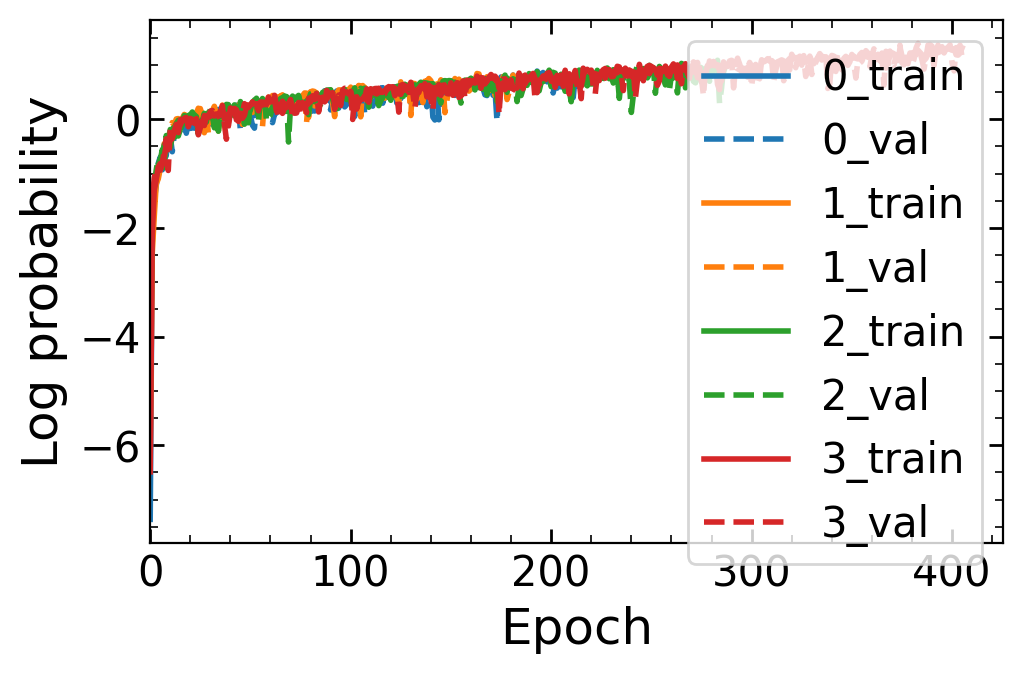

: 

In [8]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(my_width,my_height))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
fig.savefig('./train_val_loss.png')

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


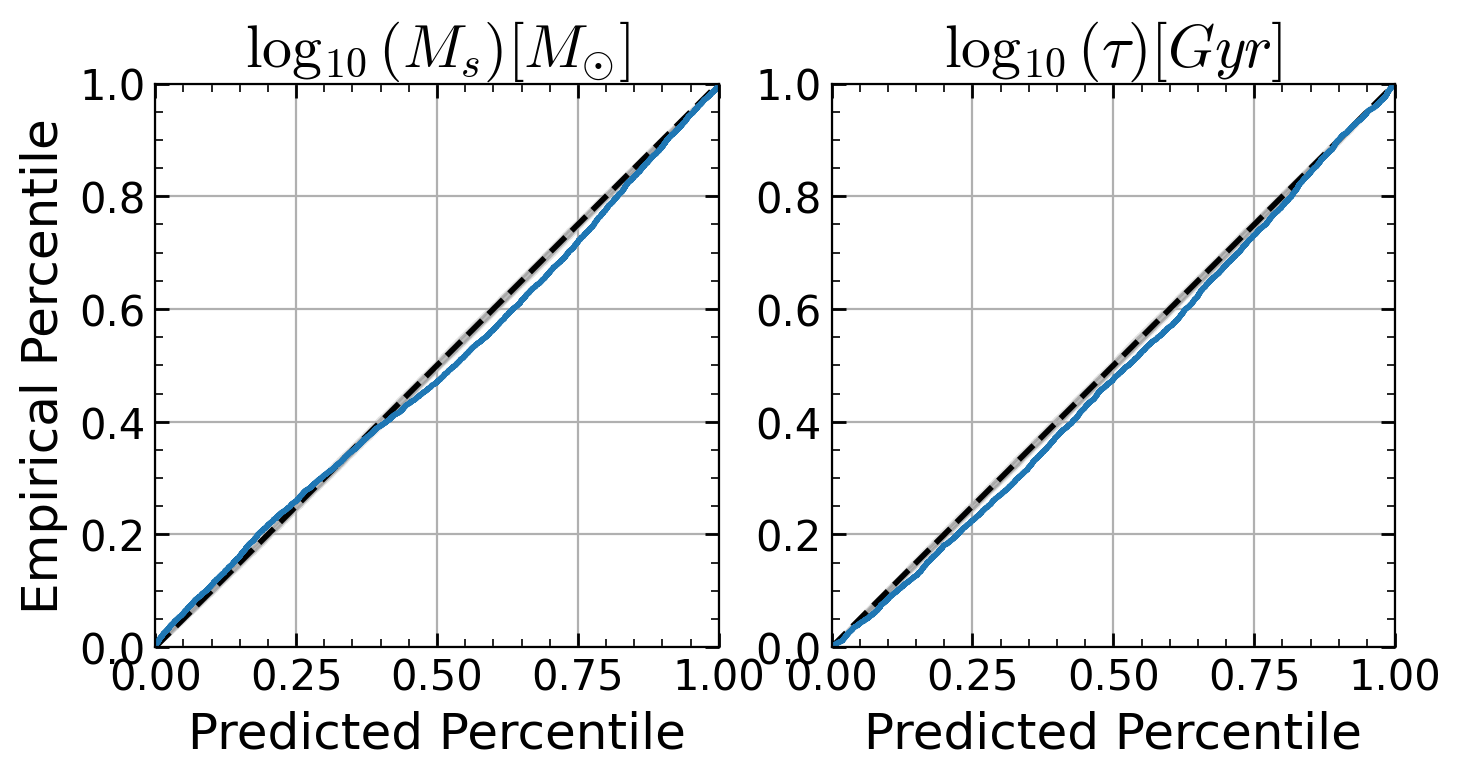

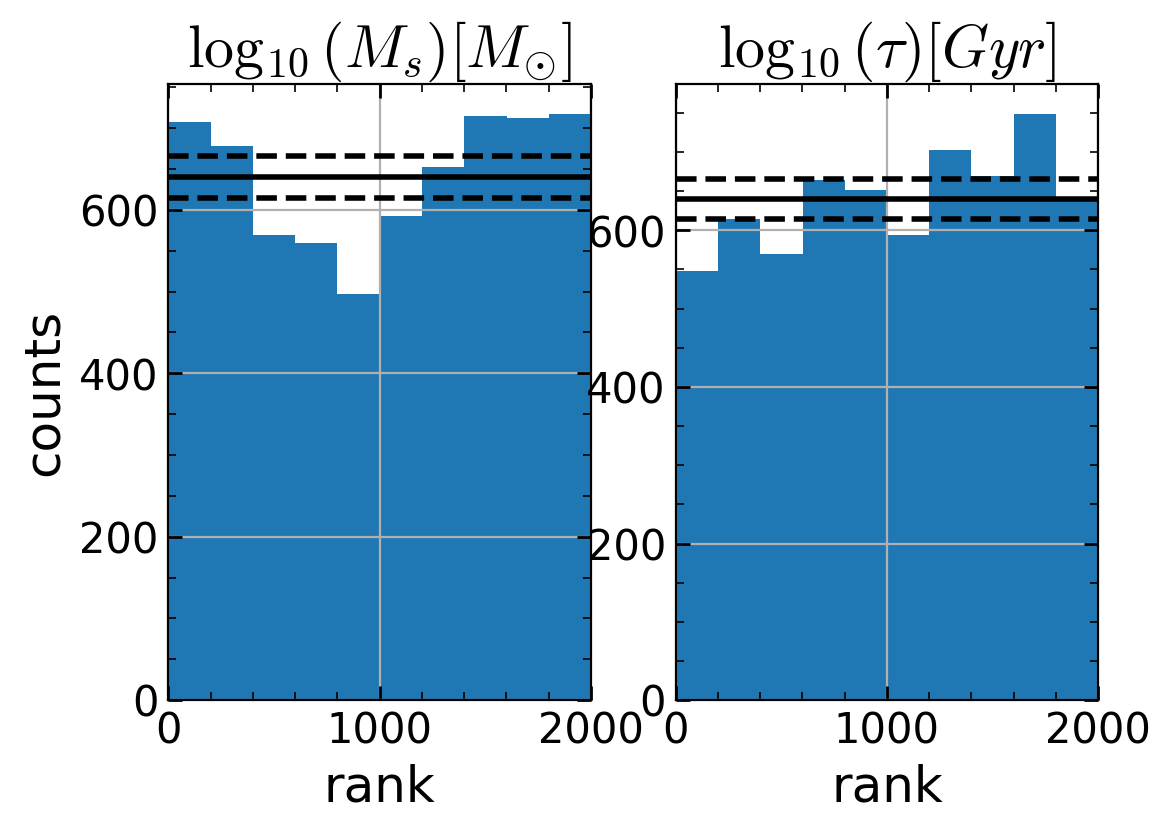

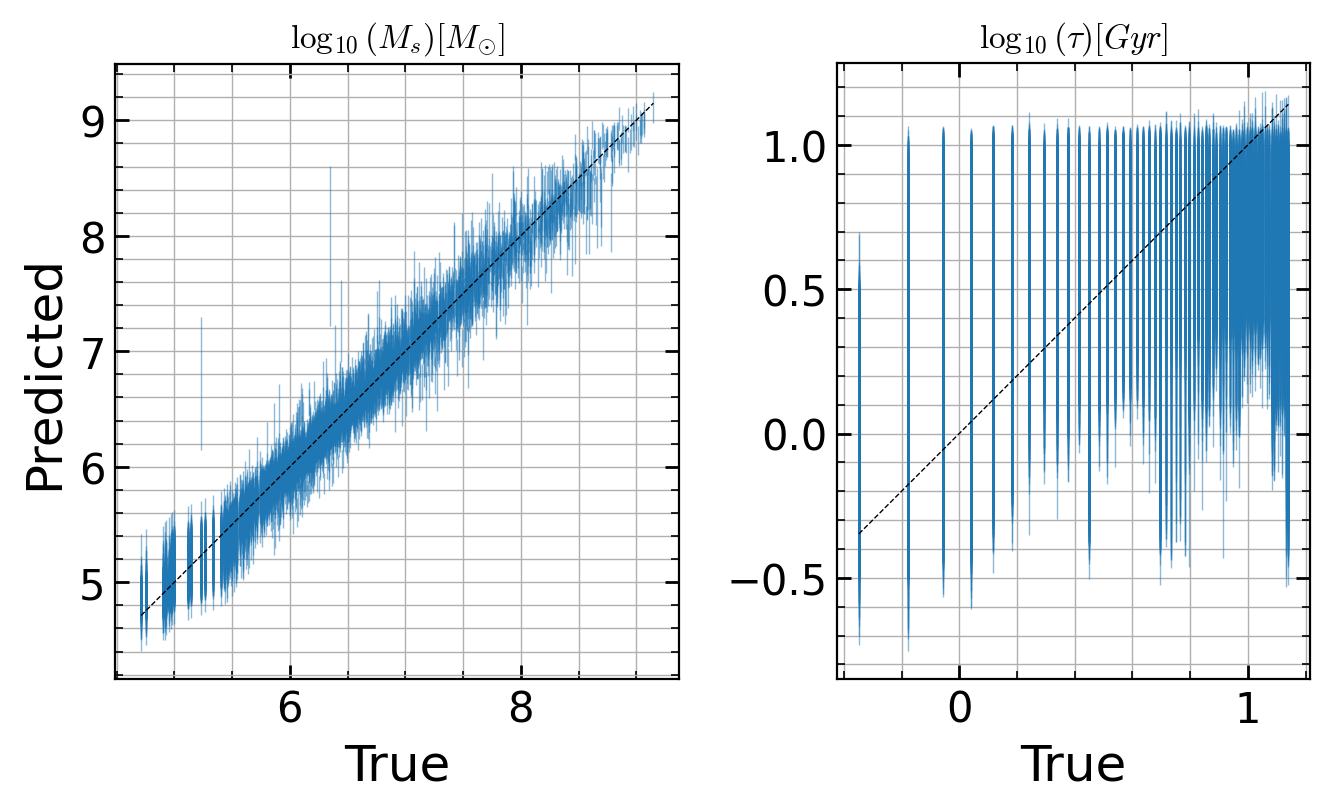

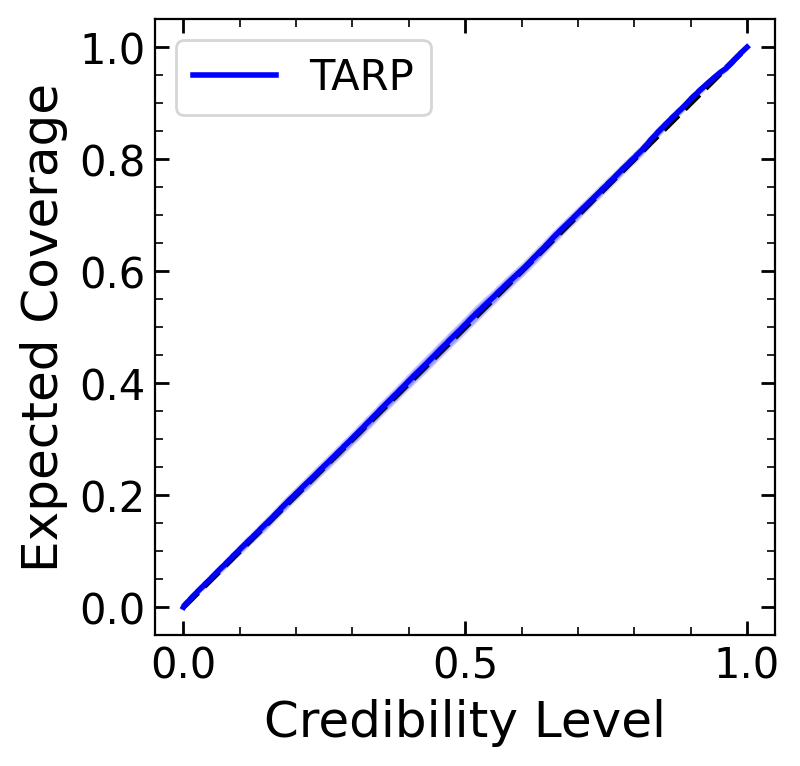

: 

In [9]:
plot_hist = ["coverage", "histogram", "predictions", "tarp"]
metric = PosteriorCoverage(
    num_samples=2_001, sample_method='direct',
    labels=[rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$', rf'$\log_{{10}}(\tau) [Gyr]$'], plot_list = plot_hist
)

fig = metric(
    posterior=posterior_ensamble,
    x=x_test, theta=params_test[:, :2])

# fig[0].savefig('./figure_3b.pdf')
# fig[1].savefig('./predictions.pdf')
# fig[2].savefig('./figure_3a.pdf')
# fig[3].savefig('./figure_3c.pdf')